In [1]:
from power_planner.utils import get_donut_vals, get_half_donut, get_distance_surface
from power_planner.constraints import ConstraintUtils
from power_planner.plotting import plot_path, plot_path_costs
import numpy as np
from graph_tool.all import Graph, shortest_path,load_graph, find_edge, remove_labeled_edges
import time
from collections import deque
import matplotlib.pyplot as plt
import os
import json
import pickle
from skimage.segmentation import watershed
from skimage import data, util, filters, color
from power_planner.utils_instance import CostUtils

## Load data and baseline:

In [89]:
instance_path = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_1.dat"
with open(instance_path, "rb") as infile:
    data = pickle.load(infile)
(instance, instance_corr, start_inds, dest_inds) = data.data

In [173]:
# FOR DATA DUMP 2
LAYER_CLASSES = ['cultural', 'human', 'planning', 'technical']
CLASS_WEIGHT = [0.28571429, 0.35714286, 0.14285714, 0.21428571]
PYLON_DIST_MIN = 7.5
PYLON_DIST_MAX = 12.5
vec = [-69, 216]
MAX_ANGLE = 0.5 * np.pi

In [3]:
# FOR DATA DUMP 5
LAYER_CLASSES = ['cultural', 'human', 'planning', 'technical']
CLASS_WEIGHT = [0.28571429, 0.35714286, 0.14285714, 0.21428571]
PYLON_DIST_MIN = 3
PYLON_DIST_MAX = 5
vec = [-69, 216]
MAX_ANGLE = 0.5 * np.pi

In [ ]:
with open("../outputs/path_19301_infos.json", "r") as infile:
    infos = json.load(infile)

In [ ]:
print(infos["path_cells"])

In [ ]:
print(np.sum(np.array(infos["edgecosts"]),axis=0))

In [ ]:
np.sum(np.array(output_paths[-1][1]), axis=0) # might be slightly different because of 0.0001

In [ ]:
# compare to output
print(np.sum(np.array(path_costs),axis=0))

### TODO:
- work on full instance only, and only edit pos2node
- start: full instance, only consider every fith node
- entweder mit downsampling, oder mit randomly deleting edges
- probability should depend on distance from path, and on cost
- randomly delete half of the edges, find new path --> add to best path


- reset graph methode?
- vary hard constraints?

Ideen:
- take min instead of mean --> searching for optimal path with minimum values

In [ ]:
instance[instance==0.0001] = 0

### Tests

In [ ]:
factor = 4
corridor = np.ones(instance_corr.shape)

In [ ]:
instance.shape, instance_corr.shape

In [ ]:
def reduce(img, scale_factor):
    x_len_new = img.shape[0] // scale_factor
    y_len_new = img.shape[1] // scale_factor
    new_img = np.zeros((x_len_new, y_len_new))
    print(y_len_new)
    for i in range(x_len_new):
        for j in range(y_len_new):
            patch = img[i * scale_factor:(i + 1) *
                        scale_factor, j *
                        scale_factor:(j + 1) * scale_factor]
            new_img[i, j] = np.mean(patch)
    return new_img

instance = np.array([reduce(inst, 4) for inst in instance])
instance_corr = reduce(instance_corr, 4)

In [ ]:
corridor = np.ones(instance_corr.shape)

In [ ]:
start_inds = start_inds//4
dest_inds = dest_inds//4

In [ ]:
dest_inds

In [ ]:
instance.shape

In [ ]:
from skimage.segmentation import watershed
from skimage import data, util, filters, color

In [ ]:
graph.set_cost_rest(4, corridor, start_inds, dest_inds)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(graph.cost_rest[2])
plt.show()

In [ ]:
inds_orig = graph.pos2node[np.mean(graph.cost_rest,axis=0) > 0]

In [ ]:
x, y = np.where(graph.cost_rest[2]>0)
out = np.zeros(instance_corr.shape)
for (i,j) in zip(x,y):
    if graph.pos2node[i,j]==-1:
        print(i,j)
        out[i,j] = 1

In [ ]:
graph.add_edges()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(graph.cost_rest[2])
plt.show()

### PIPELINE:

In [ ]:
### Initialize graph
graph = WeightedGraph(
        instance, instance_corr, graphtool=1, verbose=1
    )
graph.set_edge_costs(LAYER_CLASSES, CLASS_WEIGHT)
graph.set_shift(PYLON_DIST_MIN, PYLON_DIST_MAX, vec, MAX_ANGLE)

In [ ]:
pipeline = [(2,100), (1,0)] # scale down by factor of 4, refine with distance 100, 
# then scale down by factor of 2 in this area, refine in distance of 50
# pipeline = [(2,70), (1,0)]

In [ ]:
tic = time.time()

corridor = np.ones(instance_corr.shape)*0.5 # CHANGED # beginning: everything is included
output_paths = []

plot_surfaces = []

for (factor, dist) in pipeline:
    tic_down = time.time()
    # graph.set_cost_rest(factor, corridor, start_inds, dest_inds)
    print("time downsampling:", round(time.time()-tic_down,3))
    # plt.imshow(graph.pos2node)
    # plt.show()
    # plt.imshow(graph.cost_rest[2])
    # plt.show()
    # plot_surfaces.append(np.mean(graph.cost_rest, axis=0))
    # print("set cost rest")
    graph.add_edges(corridor)
    print("now number of edges:", len(list(graph.graph.edges())), "vertices:", len(list(graph.graph.vertices())))
    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    print("start and end:", source_v, target_v)
    # get actual best path
    path, path_costs = graph.get_shortest_path(source_v, target_v)
    output_paths.append((path, path_costs)) # save for inspection
    # get several paths --> here: pareto paths
    paths = [path] # graph.get_pareto(np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3])
    if dist > 0:
        # do specified numer of dilations
        dist_surface = get_distance_surface(graph.pos2node.shape, paths, mode="dilation", n_dilate=dist)
        # plotting
        plt.imshow(dist_surface>0)
        plt.show()
        # remove the edges of vertices in the corridor (to overwrite)
        graph.remove_vertices((dist_surface>0).astype(int)) # PYLON_DIST_MAX
        # set new corridor
        # corridor = (dist_surface >0).astype(int)
        corridor = normalize(dist_surface)

print("DONE", time.time() - tic)

In [ ]:
sm = lambda x: 1/(1+np.exp(3*(-x+5)))
plt.plot([sm(x) for x in range(10)])

In [ ]:
path, path_costs = graph.get_shortest_path(source_v, target_v)

In [ ]:
paths = graph.get_pareto(np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3])

In [ ]:
dist_surface = get_distance_surface(graph.pos2node.shape, paths, mode="dilation")

In [ ]:
plt.imshow(dist_surface>30)
plt.show()

In [ ]:
# only change cost_rest, not pos2node
# use max instead of mean --> replacing the edge is always improving it
# use find_edge to determine edges with high cost?

In [ ]:
graph.remove_vertices((dist_surface>30).astype(int))
graph.update_cost_rest((dist_surface>15).astype(int))

### Test

In [ ]:
arr = np.arange(20).reshape(4,5)

In [52]:
for v in graph.graph.vertex(target_v).in_neighbors():
    print(v)
    for u in v.in_neighbors():
        print(u)
        print([k for k in u.in_neighbors()])

327012
319761
319734
319707
319680
319653
312458
312431
312404
312377
312350
312244
[<Vertex object with index '297577' at 0x153b24570>, <Vertex object with index '297604' at 0x153e33090>, <Vertex object with index '304855' at 0x153e33390>, <Vertex object with index '312132' at 0x153e332d0>, <Vertex object with index '304882' at 0x153e334b0>, <Vertex object with index '290301' at 0x153e33510>, <Vertex object with index '290328' at 0x153e33f90>, <Vertex object with index '312159' at 0x153e33ab0>, <Vertex object with index '319410' at 0x153e33690>, <Vertex object with index '319437' at 0x153e33e10>, <Vertex object with index '326688' at 0x153e33870>, <Vertex object with index '326715' at 0x153e33cf0>, <Vertex object with index '333966' at 0x153e339f0>, <Vertex object with index '333993' at 0x153e33db0>]
312271
[]
319522
[]
319549
[]
326800
[<Vertex object with index '319415' at 0x153b24570>, <Vertex object with index '319442' at 0x153e33090>, <Vertex object with index '326665' at 0x153e3

In [43]:
print([v for v in graph.graph.vertex(6448512).out_neighbors()])

[<Vertex object with index '1062881' at 0x153e33870>]


In [40]:
target_v

<Vertex object with index '1062881' at 0x153e335d0>

In [154]:
len(list(graph.graph.edges()))

6734434

In [44]:
def edge_tuple_2_pos_tuples(n1, n2, graph):
    (x,y) = (n1//graph.n_neighbors, n1 % graph.n_neighbors)
    tup1 = ((x // graph.y_len, x % graph.y_len), (y // graph.y_len, y % graph.y_len))
    (x,y) = (n2//graph.n_neighbors, n2 % graph.n_neighbors)
    tup2 = ((x // graph.y_len, x % graph.y_len), (y // graph.y_len, y % graph.y_len))
    return tup1, tup2
edge_tuple_2_pos_tuples(6716500,1062881, graph)
# graph.angle_tuples[0]

(((922, 155), (0, 0)), ((146, 0), (0, 1)))

In [29]:
dest_inds

array([ 39, 238])

In [30]:
graph.x_len, graph.y_len

(146, 260)

In [77]:
### Initialize graph
graph = LineGraph(
        instance, instance_corr, graphtool=1, verbose=1
    )
graph.set_edge_costs(LAYER_CLASSES, CLASS_WEIGHT)
graph.set_shift(PYLON_DIST_MIN, PYLON_DIST_MAX, vec, MAX_ANGLE)

insert weight 1 for angle costs
edge costs classes: ['angle', 'cultural', 'human', 'planning', 'technical']
['angle', 'cultural', 'human', 'planning', 'technical'] [0.5        0.14285714 0.17857143 0.07142857 0.10714285]


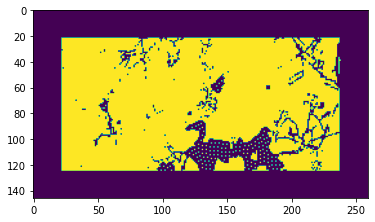

In [69]:
plt.imshow(graph.corridor)

In [78]:
graph.set_cost_rest(0.8, instance_corr, start_inds, dest_inds)

max min corridor 0.19999999999999996 -0.8
cutoff corridor vals 1.0


In [79]:
graph.add_nodes()

Added nodes: 1062880 in time: 0.07434511184692383


In [80]:
graph.add_edges()

Start adding edges... 356 iterations
Done adding edges: 1104027


In [81]:
graph.sum_costs()

In [82]:
source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)

[327012, 319761, 319734, 319707, 319680, 319653, 312458, 312431, 312404, 312377, 312350, 305099, 305072, 297821, 297794, 290543, 290516, 290489, 283266, 283239, 275988, 275961, 268766, 268739, 268712, 268685, 261462, 261435]
mean costs: [0, 0.035017520843433285, 0.011200628568163775, 0.5411923672404504, 0.4474790704852452]


In [83]:
print("start and end:", source_v, target_v)
path, path_costs = graph.get_shortest_path(source_v, target_v)

start and end: 1062880 1062881


## Graph Code

In [76]:
import numpy as np
import time
from graph_tool.all import Graph, shortest_path, load_graph

from power_planner.utils import angle, get_lg_donut, normalize
from power_planner.constraints import ConstraintUtils

from general_graph import GeneralGraph


class LineGraph(GeneralGraph):
    """
    Build a line graph for incorporating angle costs
    """

    def __init__(
        self,
        cost_instance,
        hard_constraints,
        directed=True,
        graphtool=1,
        verbose=1
    ):
        tic = time.time()
        # assert cost_instance.shape == hard_constraints.shape
        self.cost_instance = cost_instance
        self.hard_constraints = hard_constraints

        # initilize graph
        GeneralGraph.__init__(
            self, directed=directed, graphtool=graphtool, verbose=verbose
        )
        
        self.x_len, self.y_len = hard_constraints.shape

        self.time_logs = {}
        self.time_logs["init_graph"] = round(time.time() - tic, 3)
        
    def _edge2node(self, v1_arr, shift):
        """
        binary arrays of same shape as pos2v1
        """
        neighbor_ind = self.shift_dict[tuple(shift)]
        return self.pos2node[v1_arr] * self.n_neighbors + neighbor_ind
        # return self.pos2node[v1_arr] * self.n_entries + self.pos2node[v2_arr]
        
    def set_cost_rest(self, factor, corridor, start_inds, dest_inds):
        """
        factor: in this case ratio of edges to remove
        """
        assert factor < 1, "for RandomGraph factor must be smaller 1"
        self.factor = factor
        # set pos2node
        self.pos2node = np.arange(1, self.x_len * self.y_len + 1).reshape(
            (self.x_len, self.y_len)
        )
        self.n_entries = self.x_len * self.y_len
        self.n_neighbors = len(self.shifts)
        self.shift_dict = {tuple(s):i for i,s in enumerate(self.shifts)}
        
        # set corridor: exp of distances
        corridor = corridor * (self.hard_constraints > 0).astype(int)
        if self.factor == 0:
            # make sure all points in corridor are taken
            self.corridor = (corridor > 0).astype(int) * 1.1
        else:
            corridor = normalize(corridor)
            cutoff = np.quantile(corridor, factor)
            if cutoff == 1:
                self.corridor = corridor - factor
            else:
                self.corridor = corridor + 0.5 - cutoff
                # set cutoff # normalize(np.exp(
                # self.cutoff = max([0.5, cutoff])  # must be at least 0.5!
                # - 0.5 + self.cutoff
            print(
                "max min corridor", np.max(self.corridor),
                np.min(self.corridor)
            )
            print("cutoff corridor vals", cutoff)
        
    def set_cost_rest_old(self, factor, dist_surface, start_inds, dest_inds):
        # original pos2node: all filled except for hard constraints
        self.pos2node = np.arange(1, self.x_len * self.y_len + 1).reshape(
            (self.x_len, self.y_len)
        )
        self.n_entries = self.x_len * self.y_len
        self.n_neighbors = len(self.shifts)
        self.shift_dict = {tuple(s):i for i,s in enumerate(self.shifts)}
        
        corridor = (dist_surface > 0).astype(int)

        self.factor = factor
        self.cost_rest = self.cost_instance * (self.hard_constraints >
                                               0).astype(int) * corridor
        # DOWNSAMPLE
        tic = time.time()
        if factor > 1:
            self.cost_rest = CostUtils.downsample(
                self.cost_rest, factor, func="min"
            )
        self.time_logs["downsample"] = round(time.time() - tic, 3)

        # repeat because edge artifacts
        self.cost_rest = self.cost_rest * (self.hard_constraints >
                                           0).astype(int) * corridor

        # add start and end TODO ugly
        self.cost_rest[:, dest_inds[0],
                       dest_inds[1]] = self.cost_instance[:, dest_inds[0],
                                                          dest_inds[1]]
        self.cost_rest[:, start_inds[0],
                       start_inds[1]] = self.cost_instance[:, start_inds[0],
                                                           start_inds[1]]


    def set_shift(self, lower, upper, vec, max_angle):
        """
        Get donut tuples (for vertices) and angle tuples (for edges)
        """
        GeneralGraph.set_shift(self, lower, upper, vec, max_angle)
        self.angle_tuples = get_lg_donut(lower, upper, vec)

    def set_edge_costs(self, classes, weights=None):
        """
        Initialize edge properties as in super, but add angle costs
        """
        # classes = ["angle", "env", "urban"]  # data.layer_classes + ["angle"]
        classes = ["angle"] + classes
        if len(weights) < len(classes):
            print("insert weight 1 for angle costs")
            weights = [1] + list(weights)  # append angle weight
        print("edge costs classes:", classes)
        GeneralGraph.set_edge_costs(self, classes, weights=weights)

    def add_nodes(self):
        GeneralGraph.add_nodes(self, self.n_entries * self.n_neighbors)
        
    def _compute_edges(self, shift):
        """
        Get all valid edges given a certain shift
        :param mask: binary 2d array marking forbidden areas
        """
        # get all angles that are possible
        in_node = ConstraintUtils.shift_surface(
            self.hard_constraints,
            np.asarray(shift[0]) * (-1)
        )
        out_node = ConstraintUtils.shift_surface(
            self.hard_constraints,
            np.asarray(shift[1]) * (-1)
        )
        stacked = np.asarray([self.hard_constraints, in_node, out_node])
        all_angles = np.all(stacked, axis=0)

        # shift again, andersrum
        in_node = ConstraintUtils.shift_surface(
            all_angles,
            np.asarray(shift[0])
        )
        out_node = ConstraintUtils.shift_surface(
            all_angles,
            np.asarray(shift[1])
        )

        e1 = self._edge2node(in_node, np.array(shift[0])*(-1)) # in_node, all_angles,
        e2 = self._edge2node(all_angles, shift[1])

        # print(e1.shape, e2.shape)
        # print(e1[:20], e2[:20])

        # cost at edge in lg is cost of node tower inbetween
        # node_cost = [self.cost_instance[all_angles]]
        
        # new version TODO
        node_cost_list = [
            cost_surface[all_angles] for cost_surface in self.cost_rest
        ]
        node_cost_arr = np.array(node_cost_list)
        
        pos = (np.sum(node_cost_arr, axis=0) > 0).astype(bool)
        
        return e1[pos], e2[pos], node_cost_arr[:, pos] # e1, e2, node_cost_arr# 

    def add_edges(self):
        """
        Add edges to line graph: Iterate over angle tuples, retrieve nodes,
        add if angle is possible with corresponding angle cost
        """
        tic_function = time.time()

        times_edge_list = []
        times_add_edges = []
        if self.verbose:
            print(
                "Start adding edges...", len(self.angle_tuples), "iterations"
            )
        # for every angle in the new angle tuples
        for shift in self.angle_tuples:
            tic_edges = time.time()
            # get cost for angle
            
            prob_arr = np.random.rand(*self.corridor.shape)
            prob_arr = (self.corridor > prob_arr).astype(int)
            self.cost_rest = self.cost_instance * prob_arr
        
            e1, e2, node_cost_arr = self._compute_edges(shift)
            
            angle_weight = [shift[2] for _ in range(len(e1))]
            inds_arr = np.asarray([e1, e2, angle_weight])
            inds_weights = np.concatenate((inds_arr, node_cost_arr), axis=0)
            edges_lg = np.swapaxes(inds_weights, 1, 0)
            
            # save time
            times_edge_list.append(round(time.time() - tic_edges, 3))
            # add to graph
            tic_graph = time.time()
            if np.any(edges_lg[:2].flatten() < 0):
                print(np.where(out[:2] <0))
                raise RuntimeError
            self.graph.add_edge_list(edges_lg, eprops=self.cost_props)
            times_add_edges.append(round(time.time() - tic_graph, 3))

        # time logs
        self._update_time_logs(times_add_edges, times_edge_list, tic_function)

    def add_start_and_dest(self, source, dest):
        """
        start and dest are no vertices in line graph, so need to add them
        seperately
        --> get all outgoing edges from source
        --> create new start vertex, connect to all outgoing edges
        :returns: newly created source and dest vertices
        """
        tic = time.time()
        possible_start_edges = [self.pos2node[source[0], source[1]] * self.n_neighbors + self.shift_dict[tuple(shift)] for shift in self.shifts]
            
        possible_dest_edges = []
        for shift in self.shifts:
            shifted_dest = np.asarray(dest) - np.asarray(shift)
            possible_dest_edges.append(self.pos2node[shifted_dest[0], shifted_dest[1]] * self.n_neighbors + self.shift_dict[tuple(shift)])
        print(possible_dest_edges)
        
        start_v = self.graph.add_vertex()
        dest_v = self.graph.add_vertex()
        start_ind = self.graph.vertex_index[start_v]
        dest_ind = self.graph.vertex_index[dest_v]

        mean_costs = np.mean(self.cost_instance, axis=(1, 2)).tolist()
        mean_costs.insert(0, 0)  # insert zero angle cost
        print("mean costs:", mean_costs)  # TODO: leave this?

        start_edges = [
            [start_ind, u] + mean_costs for u in possible_start_edges
        ]
        dest_edges = [[u, dest_ind] + mean_costs for u in possible_dest_edges]
        self.graph.add_edge_list(start_edges, eprops=self.cost_props)
        self.graph.add_edge_list(dest_edges, eprops=self.cost_props)

        self.time_logs["add_start_end"] = round(time.time() - tic, 3)

        return [start_v, dest_v]

    def get_shortest_path(self, source, dest):
        """
        Compute shortest path and convert from line graph representation to 
        coordinates
        """
        vertices_path = GeneralGraph.get_shortest_path(self, source, dest)
        out_path = []
        for v in vertices_path[1:-1]:
            (start_node, shift_ind) = (int(v)//graph.n_neighbors, int(v) % graph.n_neighbors)
            start_pos = [start_node // graph.y_len, start_node % graph.y_len]
            out_path.append(start_pos)
        
        # append last on
        out_path.append(list(np.array(start_pos) + self.shifts[shift_ind]))
        
        out_costs = []
        for (i, j) in out_path:
            out_costs.append(self.cost_instance[:, i, j].tolist())
            
        return out_path, out_costs


    

In [4]:
class GeneralGraph():

    def __init__(self, graphtool=1, directed=True, verbose=1):
        if graphtool:
            self.graph = Graph(directed=directed)
            self.weight = self.graph.new_edge_property("float")
        else:
            if directed:
                print("directed graph")
                self.graph = nx.DiGraph()
            else:
                self.graph = nx.Graph()
        self.time_logs = {}
        self.verbose = verbose
        self.graphtool = graphtool

    def set_edge_costs(self, classes, weights=None):
        if weights is None:
            weights = [1 for i in range(len(classes))]
        weights = np.array(weights)
        # set different costs:
        self.cost_classes = classes
        self.cost_props = [
            self.graph.new_edge_property("float") for _ in range(len(classes))
        ]
        self.cost_weights = weights / np.sum(weights)
        print(self.cost_classes, self.cost_weights)

    def set_shift(self, lower, upper, vec, max_angle):
        self.shifts = get_half_donut(lower, upper, vec, angle_max=max_angle)

    def add_nodes(self, nodes):
        """
        param nodes: list of node names if networkx, integer if graphtool
        """
        tic = time.time()
        # add nodes to graph
        if self.graphtool:
            _ = self.graph.add_vertex(nodes)
        else:
            self.graph.add_nodes_from(np.arange(nodes))
        # verbose
        if self.verbose:
            print("Added nodes:", nodes, "in time:", time.time() - tic)
        self.time_logs["add_nodes"] = round(time.time() - tic, 3)

    def sum_costs(self):
        # add sum of all costs
        tic = time.time()
        summed_costs_arr = np.zeros(self.cost_props[0].get_array().shape)
        for i in range(len(self.cost_props)):
            prop = self.cost_props[i].get_array()
            summed_costs_arr += prop * self.cost_weights[i]
        self.weight.a = summed_costs_arr

        self.time_logs["sum_of_costs"] = round(time.time() - tic, 3)

    def get_pareto(self, vary, source, dest, out_path=None, compare=[0, 1]):
        """
        compute shortest paths with varied weights
        """
        pareto = list()
        paths = list()
        cost0 = self.cost_props[compare[0]].get_array()
        cost1 = self.cost_props[compare[1]].get_array()
        class0 = self.cost_classes[compare[0]]
        class1 = self.cost_classes[compare[1]]
        # test_edge = find_edge(self.graph, self.graph.edge_index, 44)[0]
        for w in vary:
            self.weight.a = cost0 * w + cost1 * (1 - w)
            # print("test weight", self.weight[test_edge])
            path, path_costs = self.get_shortest_path(source, dest)
            # print(
            #     class0, "weight:", w, class1, "weight:", 1 - w, "costs:",
            #     np.mean(path_costs, axis=0)
            # )
            pareto.append(np.sum(path_costs, axis=0))
            paths.append(path)
        # PLOTTING:
        # pareto = np.asarray(pareto)
        # pareto0 = pareto[:, compare[0]]
        # pareto1 = pareto[:, compare[1]]
        # plot_pareto(
        #     pareto0, pareto1, paths, vary, [class0, class1], out_path=out_path
        # )
        # plot_pareto_paths(paths, [class0, class1], out_path=out_path)
        return paths

    def get_shortest_path(self, source, target):
        """
        Compute shortest path from source vertex to target vertex
        """
        tic = (time.time())
        # #if source and target are given as indices:
        if self.graphtool:
            vertices_path, _ = shortest_path(
                self.graph,
                source,
                target,
                weights=self.weight,
                negative_weights=True
            )
        else:
            vertices_path = nx.dijkstra_path(self.graph, source, target)

        self.time_logs["shortest_path"] = round(time.time() - tic, 3)
        return vertices_path

    def save_graph(self, OUT_PATH):
        if self.graphtool:
            for i, cost_class in enumerate(self.cost_classes):
                self.graph.edge_properties[cost_class] = self.cost_props[i]
            self.graph.edge_properties["weight"] = self.weight
            self.graph.save(OUT_PATH + ".xml.gz")
        else:
            nx.write_weighted_edgelist(
                self.graph, OUT_PATH + '.weighted.edgelist'
            )

    def load_graph(self, IN_PATH):
        if self.graphtool:
            self.g_prev = load_graph(IN_PATH + ".xml.gz")
            self.weight_prev = self.g_prev.ep.weight
            # weight = G2.ep.weight[G2.edge(66, 69)]
        else:
            self.g_prev = nx.read_edgelist(
                IN_PATH + '.weighted.edgelist',
                nodetype=int,
                data=(('weight', float), )
            )

# Evaluation

In [ ]:
plot_path_costs(graph.cost_rest, (np.array(infos["path_cells"])/2).astype(int), infos["edgecosts"], graph.cost_classes)

In [ ]:
linear infrastructure, optimal path planning, network OPTLINE, optimal power transport by LOPT LION 
optimal power transport infrastructure by LIOPT graph modeling 

In [ ]:
np.sum(np.array(output_paths[-1][1]), axis=0)

In [ ]:
def plot_pipeline_paths(plot_surfaces, output_paths, buffer=1, out_path=None):
    """
    subplots of different steps in the pipeline
    """
    plt.figure(figsize=(20, 10))
    for i, (p, p_cost) in enumerate(output_paths):
        plt.subplot(1, len(output_paths), i + 1)

        # expand to greyscale
        expanded = np.expand_dims(plot_surfaces[i], axis=2)
        expanded = np.tile(
            expanded, (1, 1, 3)
        )  # overwrite instance by tiled one
        # colour nodes in path in red
        for (x, y) in p:
            expanded[x - buffer:x + buffer + 1, y - buffer:y + buffer +
                     1] = [0.9, 0.2, 0.2]  # colour red
        plt.imshow(np.swapaxes(expanded, 1, 0), origin="lower")
        print("costs", np.sum(np.array(p_cost), axis=0))
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
print(np.sum(np.array(output_paths[-1][1]), axis=0))

In [59]:
dest_inds

array([ 39, 238])

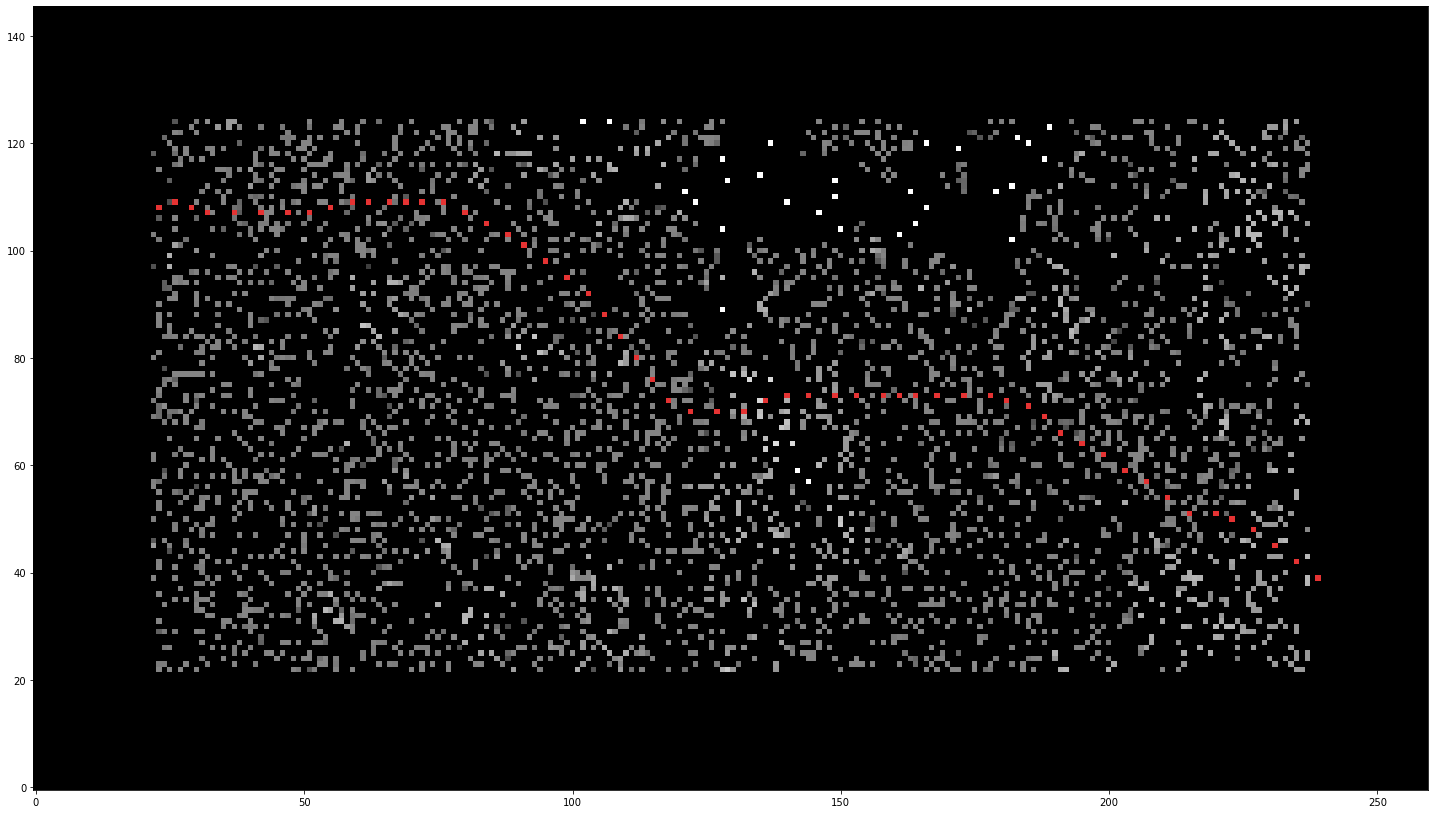

In [84]:
plot_path(graph.cost_rest[2], path, buffer=0) # graph.cost_rest[2], output_paths[-1][0])

In [ ]:
plot_pipeline_paths(plot_surfaces, output_paths, buffer=1, out_path=None)

In [ ]:
gt = np.array(infos["path_cells"])
costs_new = []
for i in range(len(gt)-1):
    (h,j) = gt[i]
    (k,l) = gt[i+1]
    v1 = graph.pos2node[int(h//2), j//2]
    v2 = graph.pos2node[int(k//2), l//2]
    found=False
    for w in graph.graph.vertex(v1).out_neighbors():
        if w==v2:
            found=True
    # print(found)
    e = graph.graph.edge(graph.graph.vertex(v1), graph.graph.vertex(v2))
    c = [cost[e] for cost in graph.cost_props]
    costs_new.append(c)

In [ ]:
np.sum(np.array(costs_new), axis=0)

### Tests:

In [ ]:
# TEST THAT EDGES ARE NOT OVERWRITTEN - MULTIGRAPH
g = Graph()
w = g.new_edge_property("float")
edges = []
for i in range(20):
    edges.append([i,i+1,i])
g.add_edge_list(edges, eprops=[w])
# e = find_edge(g, g.edge_index, 13)

new_edges = []
for i in range(15,20):
    new_edges.append([i,i+1,i-5])
g.add_edge_list(new_edges, eprops=[w])

e = g.add_edge(g.vertex(13), g.vertex(14))
w[e] = 10

for e in g.edges():
    print(e)
    print(w[e])

In [ ]:
from power_planner.utils import normalize
dist_surface = normalize(dist_surface)

In [ ]:
dists_orig = get_distance_surface(dist_surface.shape, [path], n_dilate=200)
# get_distance_surface(graph.pos2node.shape, paths, mode="dilation", n_dilate=dist)



In [ ]:
dists = normalize(np.exp(normalize(dists_orig)))

In [ ]:
ratio_rem = 0.99
cutoff = np.quantile(dists, ratio_rem)
print(cutoff)

In [ ]:
arr = np.random.rand(*dist_surface.shape)-0.5+cutoff # (arr-cutoff+0.5)
print(np.mean(arr))
prob_arr = (dists > arr).astype(int)

In [ ]:
plt.imshow(prob_arr)
plt.colorbar()
plt.show()

In [ ]:
print("prob kept", np.sum((prob_arr>0).astype(int)) / (arr.shape[0]*arr.shape[1]))

In [ ]:
print()

In [ ]:
cutoff = np.quantile(dist_surface/100, 0.25)
prob_arr = (dist_surface/100 > (arr-cutoff+0.5)).astype(int)

In [ ]:
# number of edges we want in the end --> divide

In [ ]:
# set self.cost_rest different for every shift --> multiply self.cost_instance

In [ ]:
def update_cost_rest(self, corridor):
        # UNUSED method
        inverted_corridor = np.absolute(1-corridor).astype(bool)
        self.pos2node[inverted_corridor] = -1
        
    def set_pos2node(self, img, factor):
        # UNUSED METHOD
        x_len_new = img.shape[1] // factor
        y_len_new = img.shape[2] // factor
        pos2node = np.zeros((img.shape[1], img.shape[2]))
        new_img = np.zeros(img.shape)
        pos2node += -1
        lab = 0
        for i in range(x_len_new):
            for j in range(y_len_new):
                patch = img[:, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
                if np.any(patch):
                    pos2node[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor] = lab
                    lab += 1
                # x_cost = int(mean([i * factor, (i + 1) * factor])
                    for k in range(len(new_img)):
                        part = patch[k]
                        if np.any(part):
                            new_img[k, i*factor, j*factor] = np.mean(part[part>0])
        return pos2node, new_img

